# <font color='red'>**Sequence to sequence implementation**</font>

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. Implement a simple Encoder and Decoder architecture  

4.  BLEU score as metric to evaluate your model.

5. Use Tensorboard to plot the Graph, Scores and histograms of gradients. 

    



<font color='blue'>**Load the data**</font>

In [1]:
!wget http://www.manythings.org/anki/ita-eng.zip

--2022-01-24 19:51:40--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3030::6815:5c2c, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7757958 (7.4M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.40M  40.3MB/s    in 0.2s    

2022-01-24 19:51:41 (40.3 MB/s) - ‘ita-eng.zip’ saved [7757958/7757958]



In [2]:
!unzip ita-eng.zip

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


<font color='blue'>**Preprocess data**</font>

In [3]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2022-01-24 19:52:10--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2022-01-24 19:52:10--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc20ceb1fdda04cf0b28c6f4b3b0.dl.dropboxusercontent.com/cd/0/inline/Bea7Lw19yPlapn-6NTbzouZB8yDNROdQiPpVIRYwI4bs-QD1m2xRh-rxY37MmZKdptn7kCoGpln5fAlSqIx2YLptp8UzSCRoGPa_IqkRMnxcceYUnG_6OTxicgB0zq52yPi2FvSXmWFiSUlvGgtKYa5d/file# [following]
--2022-01-24 19:52:10--  https://uc20ceb1fdda04cf0b28c6f4b3b0.dl.dropboxusercontent.com/cd/0/inline/Bea7Lw19yPlapn-6NTbzouZB8yDNROdQiPpVIRYwI4bs-QD1m2xRh-rxY37MmZKdptn7kCoGpln

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau,EarlyStopping
import nltk.translate.bleu_score as bleu
from tqdm import tqdm
import random
from nltk.translate import bleu_score

In [5]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(353281, 2)


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


In [6]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # I have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [7]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [8]:
data.sample(10)

,italian,english_inp,english_out
289143,non è facile parlare bene in francese,<start> it is not easy to speak french well,it is not easy to speak french well <end>
352481,linsegnante ha affermato che ci avrebbe fatto ...,<start> the teacher claimed that he would have...,the teacher claimed that he would have us all ...
94461,i ragazzi hanno sete,<start> the boys are thirsty,the boys are thirsty <end>
21748,le due si sono baciate,<start> the two kissed,the two kissed <end>
349746,che tipo di birra vuoi coshai alla spina,<start> what kind of beer do you want what do ...,what kind of beer do you want what do you have...
106694,io mi prenderò cura di te,<start> i will take care of you,i will take care of you <end>
174771,tom è un battitore molto bravo,<start> tom is a very good batter,tom is a very good batter <end>
79958,anche loro mi hanno aiutato,<start> they helped me too,they helped me too <end>
77325,sto cercando delle risposte,<start> i am seeking answers,i am seeking answers <end>
112028,a tom serve un ombrello,<start> tom needs an umbrella,tom needs an umbrella <end>


In [9]:
data.to_csv('preprocessed_seq',index=False)

In [10]:
data2=pd.read_csv('preprocessed_seq')

In [11]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data2, test_size=0.2)

In [12]:
print(train.shape, validation.shape)

(282230, 3) (70558, 3)


In [13]:

# for one sentence I will be adding <end> token so that the tokanizer learns the word <end>
# with this I can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

In [14]:
train.head(10)

,italian,english_inp,english_out
51527,lei ha una foto,<start> she has a picture <end>,she has a picture <end> <end>
148404,ti sei divertita stasera,<start> did you have fun tonight,did you have fun tonight <end>
160795,abbiamo finito lo zucchero,<start> we have run out of sugar,we have run out of sugar <end>
328671,sembra carina a prescindere da quello che indossa,<start> she looks pretty no matter what she wears,she looks pretty no matter what she wears <end>
88315,come siamo venuti qui,<start> how did we come here,how did we come here <end>
302079,ha detto di essere già stato alle hawaii,<start> he said he had been to hawaii before,he said he had been to hawaii before <end>
216487,io pensavo che tom fosse canadese,<start> i thought tom was a canadian,i thought tom was a canadian <end>
74486,non ho una moglie,<start> i do not have a wife,i do not have a wife <end>
180345,sai chi vive qui,<start> do you know who lives here,do you know who lives here <end>
279779,preferirei essere qui che a boston,<start> i would rather be here than in boston,i would rather be here than in boston <end>


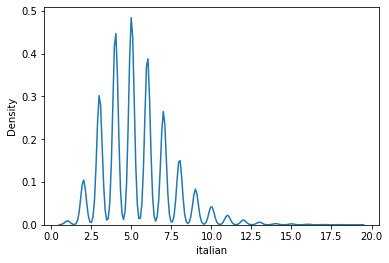

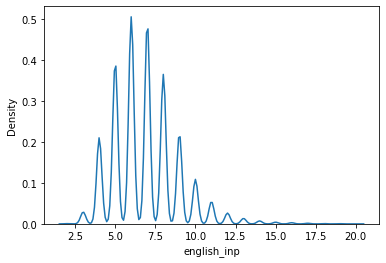

In [15]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [16]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [17]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

13121
26649


In [18]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10365)

In [19]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [20]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, enc_vocab_size, embedding_dim, enc_lstm_size, input_length):
        super().__init__()
        self.enc_vocab_size = enc_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.encoder_output=0
        self.lstm_size=enc_lstm_size
        self.lstm_output = 0
        self.enc_state_h=0
        self.enc_state_c=0
      
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.enc_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")
        
    def call(self, input_sentances, training=True):
        input_embedd= self.embedding(input_sentances)
        self.encoder_output, self.enc_state_h,self.enc_state_c = self.lstm(input_embedd)
        return self.encoder_output, self.enc_state_h,self.enc_state_c

    def initialize_states(self, batch_size):

        lstm_h=tf.zeros(shape=[batch_size,self.lstm_size])
        lstm_c=tf.zeros(shape=[batch_size,self.lstm_size])

        return [lstm_h,lstm_c]


<font color='orange'>**Grader function - 1**</font>

In [21]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


In [22]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, dec_vocab_size, embedding_dim, dec_lstm_size,input_length):
        super().__init__()
        self.vocab_size = dec_vocab_size
        self.embedding_dim = 100
        #self.dec_units = dec_units
        self.lstm_size=dec_lstm_size
        self.input_length = input_length
        # we are using embedding_matrix and not training the embedding layer
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_decoder")
        self.lstm = LSTM(self.lstm_size, return_sequences=True, return_state=True, name="Decoder_LSTM")
    
    def call(self, target_sentances, initial_state):
        target_embedd = self.embedding(target_sentances)
        decoder_output,lstm_h,lstm_c = self.lstm(target_embedd, initial_state)
        return decoder_output,lstm_h,lstm_c

In [ ]:
# intial_hidden_state=np.zeros((batch_size,self.lstm_size))
# intial_cell_state=np.zeros((batch_size,self.lstm_size))

<font color='orange'>**Grader function - 2**</font>

In [23]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
        
    
    '''
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())

True


In [24]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self, enc_inputs_len,dec_inputs_len, ed_vocab_size,batch_size):
        
        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'

        super().__init__()

        self.enc=Encoder(enc_vocab_size=vocab_size_ita+1,embedding_dim=50,enc_lstm_size=256,input_length=enc_inputs_len)
        self.dec=Decoder(dec_vocab_size=vocab_size_eng+1,embedding_dim=100,dec_lstm_size=256,input_length=dec_inputs_len)
        self.dense_ed=Dense(ed_vocab_size, activation='softmax')
        self.enc_states=self.enc.initialize_states(batch_size)
    
    
    def call(self,input_ed):

      data_enc=input_ed[0]
      data_dec=input_ed[1]
      encoder_output,final_state_h,final_state_c=self.enc(data_enc,self.enc_states)
      decoder_output,state_h,state_c=self.dec(data_dec,[final_state_h,final_state_c])
      dense_ed=self.dense_ed(decoder_output)

      return dense_ed
        

In [25]:
class Data_en:
    def __init__(self, data2, tknizer_ita, tknizer_eng, len_data):
        self.in_encoder = data2['italian'].values
        self.in_decoder = data2['english_inp'].values
        self.out_decoder = data2['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.len_data = len_data

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.in_encoder[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.in_decoder[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.out_decoder[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.len_data, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.len_data, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.len_data, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.in_encoder)

    
class LoadData(tf.keras.utils.Sequence):    
    def __init__(self, data_lan, batch_size=1):
        self.data_lan = data_lan
        self.batch_size = batch_size
        self.index_data = np.arange(len(self.data_lan.in_encoder))


    def __getitem__(self, i):
        a = i * self.batch_size
        b = (i + 1) * self.batch_size
        data_val = []
        for j in range(a, b):
            data_val.append(self.data_lan[j])

        batch_data = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data_val)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch_data[0],batch_data[1]],batch_data[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.index_data) // self.batch_size

    def on_epoch_end(self):
        self.index_data = np.random.permutation(self.index_data)

In [26]:
train_enc1 = Data_en(train, tknizer_ita, tknizer_eng, 20)
test_ecn1  = Data_en(validation, tknizer_ita, tknizer_eng, 20)

train_load = LoadData(train_enc1, batch_size=1024)
test_load = LoadData(test_ecn1, batch_size=1024)


print(train_load[0][0][0].shape, train_load[0][0][1].shape, train_load[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
import os
import datetime
%load_ext tensorboard
logdir1 = os.path.join("logs1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback1= tf.keras.callbacks.TensorBoard(logdir1, histogram_freq=1)

model1=Encoder_decoder(enc_inputs_len=20,dec_inputs_len=20,ed_vocab_size=vocab_size_eng,batch_size=1024)
model1.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy')
train_steps1=train.shape[0]//1024
valid_steps1=validation.shape[0]//1024
model1.fit(train_load, steps_per_epoch=train_steps1, epochs=35, validation_data=train_load, validation_steps=valid_steps1,callbacks=[tensorboard_callback1])

Epoch 1/35
274/274 [==============================] - 88s 295ms/step - loss: 1.8474 - val_loss: 1.6069
Epoch 2/35
274/274 [==============================] - 71s 259ms/step - loss: 1.4759 - val_loss: 1.3590
Epoch 3/35
274/274 [==============================] - 71s 258ms/step - loss: 1.2951 - val_loss: 1.2232
Epoch 4/35
274/274 [==============================] - 82s 298ms/step - loss: 1.1606 - val_loss: 1.0843
Epoch 5/35
274/274 [==============================] - 72s 263ms/step - loss: 1.0302 - val_loss: 0.9641
Epoch 6/35
274/274 [==============================] - 71s 260ms/step - loss: 0.9232 - val_loss: 0.8679
Epoch 7/35
274/274 [==============================] - 71s 260ms/step - loss: 0.8336 - val_loss: 0.7833
Epoch 8/35
274/274 [==============================] - 71s 259ms/step - loss: 0.7548 - val_loss: 0.7082
Epoch 9/35
274/274 [==============================] - 82s 298ms/step - loss: 0.6850 - val_loss: 0.6437
Epoch 10/35
274/274 [==============================] - 72s 261ms/step - l

In [ ]:
model1.summary()

Model: "encoder_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  1643268   
_________________________________________________________________
decoder_1 (Decoder)          multiple                  1673368   
_________________________________________________________________
dense (Dense)                multiple                  3360789   
Total params: 6,677,425
Trainable params: 6,677,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.save_weights('encoder_decoder_task1.h5')

In [27]:
def predict(input_sentence):

  in_enc_ita=tknizer_ita.texts_to_sequences([input_sentence])
  in_pad_seq_ita=pad_sequences(in_enc_ita,maxlen=20,padding='post',truncating='post',dtype='int32')
  embed_pred=model1.layers[0].embedding(in_pad_seq_ita)
  enc_ouput1,enc_state_h1,enc_state_c1=model1.layers[0].lstm(embed_pred)
  in_indexs_2d=tknizer_eng.word_index['<start>']
  in_indexs_2d=np.reshape(in_indexs_2d,(1,1))
  att=np.zeros((20,20))
  input_list=[]
  for j in range(20):
    out_pred,dec_state_h1,dec_state_c1=model1.layers[1](in_indexs_2d,[enc_state_h1,enc_state_c1])
    dense_out1=model1.layers[2](out_pred)
    enc_state_h1=dec_state_h1
    enc_state_c1=dec_state_c1
    out_index=np.argmax(dense_out1)
    in_indexs_2d=np.reshape(out_index,(1,1))
    input_list.append(tknizer_eng.index_word[out_index])
    if tknizer_eng.index_word[out_index]=='<end>':
      break
  return ' '.join(input_list)


In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [ ]:
ita=validation['italian'].values[:1000]
eng=validation['english_out'].values[:1000]
blue=[]
for i in range(1000):
  pred_bl=predict(ita[i])
  blue.append(bleu_score.sentence_bleu(eng[i],pred_bl))


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print(f'Bleu_score: {np.average(blue)}')

Bleu_score: 0.8361471092114097


## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [28]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, enc_vocab_size, embedding_dim, enc_lstm_size, input_length):
        super().__init__()
        self.enc_vocab_size = enc_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.encoder_output=0
        self.lstm_size=enc_lstm_size
        self.lstm_output = 0
        self.enc_state_h=0
        self.enc_state_c=0
      
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.enc_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM")
        
    def call(self, input_sentances, training=True):
        input_embedd= self.embedding(input_sentances)
        self.encoder_output, self.enc_state_h,self.enc_state_c = self.lstm(input_embedd)
        return self.encoder_output, self.enc_state_h,self.enc_state_c

    def initialize_states(self, batch_size):

        lstm_h=tf.zeros(shape=[batch_size,self.lstm_size])
        lstm_c=tf.zeros(shape=[batch_size,self.lstm_size])

        return [lstm_h,lstm_c]

<font color='cyan'>**Grader function - 1**</font>

In [29]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [30]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()
    self.scoring_function=scoring_function
    # Please go through the reference notebook and research paper to complete the scoring functions
    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
      self.att_units=att_units
      self.softmax1=tf.keras.layers.Softmax(axis=1)
    if scoring_function == 'general':
      # Intialize variables needed for General score function here
      # Initializing the weights
      self.dense1=tf.keras.layers.Dense(self.att_units)
      self.softmax1=tf.keras.layers.Softmax(axis=1)
    elif scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
      self.dense2=tf.keras.layers.Dense(self.att_units,activation='tanh')
      self.dense_att=tf.keras.layers.Dense(1)
      self.softmax1=tf.keras.layers.Softmax(axis=1)
  
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    if self.scoring_function == 'dot':
        
        # Implement Dot score function here
        d1=tf.keras.layers.Dot(axes=(2,1))([encoder_output,tf.reshape(decoder_hidden_state,
                                                  [decoder_hidden_state.shape[0],decoder_hidden_state.shape[1],1])])
        d1_softmax=self.softmax1(d1)
        
        
        #Find the context vector
        d2=tf.keras.layers.Dot(axes=(1,2))([d1_softmax,
                                                  tf.reshape(encoder_output,shape=[encoder_output.shape[0],encoder_output.shape[2],encoder_output.shape[1]])])
        dt_dot=tf.reshape(d2,shape=[d2.shape[0],d2.shape[2]])
        return dt_dot,d1_softmax

    elif self.scoring_function == 'general':
        # Implement General score function here
        d1=self.dense1(decoder_hidden_state)
        dt3=tf.reshape(d1,[d1.shape[0],d1.shape[1],1])
        dt_general=tf.keras.layers.Dot(axes=(2,1))([encoder_output,dt3])
        weights_general=self.softmax1(tf.cast(dt_general,dtype='float32'))
        

        # Find the context vector
        d2=tf.keras.layers.Dot(axes=(1,2))([weights_general,tf.reshape(encoder_output,shape=[encoder_output.shape[0],encoder_output.shape[2],encoder_output.shape[1]])])
        vector_general=tf.reshape(d2,shape=[d2.shape[0],d2.shape[2]])
        return vector_general,weights_general

                                                                             

    elif self.scoring_function == 'concat':
        
        # Implementing concat function
        dense_concat=self.dense_att(self.dense2(encoder_output)+tf.expand_dims(self.dense2(decoder_hidden_state),1))
        softmax_concat=self.softmax1(tf.cast(dense_concat,dtype='float32'))#Finding the attention weight

        #Finding the context vector

        d2=tf.keras.layers.Dot(axes=(1,2))([softmax_concat,
                                                  tf.reshape(encoder_output,shape=[encoder_output.shape[0],encoder_output.shape[2],encoder_output.shape[1]])])
        vector_concat=tf.reshape(d2,shape=[d2.shape[0],d2.shape[2]])
        return vector_concat,softmax_concat


<font color='cyan'>**Grader function - 2**</font>

In [ ]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


<font color='blue'>**OneStepDecoder**</font>

In [ ]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      super().__init__()

      self.tar_vocab_size=tar_vocab_size
      self.embedding_dim=embedding_dim
      self.input_length=input_length
      self.dec_units=dec_units
      self.score_fun=score_fun
      self.att_units=att_units

      self.embed_osd=Embedding(input_dim = self.tar_vocab_size, output_dim = self.embedding_dim,
                                      input_length = self.input_length, name="embedding_layer_osd")
      self.lst_osd= LSTM(self.dec_units, return_sequences=True,return_state=True,name="osd_LSTM")
       
      self.att_osd = Attention(self.score_fun,self.att_units)

      self.dense_osd = Dense(self.tar_vocab_size)
    
  def call(self,input_to_decoder, encoder_output, state_h,state_c):

    vec_osd,wgt=self.att_osd(state_h,encoder_output)
    embed_target=self.embed_osd(input_to_decoder)
    t=tf.expand_dims(vec_osd,1)
    cnct=tf.concat([embed_target,t],axis=2)
    output_osd,hid_osd,cell_osd=self.lst_osd(cnct)
    output_osd=tf.reshape(output_osd,(-1,output_osd.shape[2]))
    output_osd=self.dense_osd(output_osd)
    return output_osd,hid_osd,cell_osd,wgt,vec_osd


<font color='cyan'>**Grader function - 3**</font>

In [ ]:
def grader_onestepdecoder(score_fun):
    
    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=OneStepDecoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))
    

True
True
True


<font color='blue'>**Decoder**</font>

In [31]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super().__init__()
      self.out_vocab_size=out_vocab_size
      self.embedding_dim= embedding_dim
      self.input_length =input_length
      self.dec_units=dec_units
      self.score_fun=score_fun
      self.att_units=att_units
      self.onestep_decoder = OneStepDecoder(self.out_vocab_size,self.embedding_dim,self.input_length,self.dec_units, self.score_fun,self.att_units)
    
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):
      var=tf.TensorArray(tf.float32,size=len(input_to_decoder[0]),name='tensor_deocoder')
      for i in range(len(input_to_decoder[0])):
        out1,hid_dec,cell_dec,wgt_dec,cnv_vec=self.onestep_decoder(input_to_decoder[:,i:i+1],encoder_output,decoder_hidden_state,decoder_cell_state)
        var=var.write(i,out1)
      var=tf.transpose(var.stack(),[1,0,2])
      return var

<font color='cyan'>**Grader function - 4**</font>

In [ ]:
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


<font color='blue'>**Encoder Decoder model**</font>

In [32]:
class encoder_decoder(tf.keras.Model):
    
    def __init__(self, input_len,output_len, score_ecm,att_units,batch_size):
        
        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'

        super().__init__()
        self.input_len=input_len
        self.output_len=output_len
        self.score_ecm=score_ecm
        self.batch_size=batch_size
        self.att_units=att_units
        self.enc=Encoder(enc_vocab_size=vocab_size_ita+1,embedding_dim=50,input_length=input_len,enc_lstm_size=256)
        self.dec=Decoder(out_vocab_size=vocab_size_eng+1,embedding_dim=100,dec_units=256,input_length=self.output_len,score_fun=self.score_ecm,att_units=self.att_units)
        self.enc_state1,self.encoder_state2=self.enc.initialize_states(self.batch_size)
    
    
    def call(self,input_ed):
      enc_output,enc_hid,enc_cell=self.enc(input_ed[0],[self.enc_state1,self.encoder_state2])
      decoder_output=self.dec(input_ed[1],enc_output,enc_hid,enc_cell)

      return decoder_output
        

<font color='blue'>**Custom loss function**</font>

In [ ]:
loss1= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def custom_lossfunction(targets,logits):

  # Custom loss function that will not consider the loss for padded zeros.
  # Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function
  
  target=tf.math.logical_not(tf.math.equal(targets,0))
  loss2=loss1(targets,logits)
  #masking loss for padding
  
  target=tf.cast(target,dtype=loss2.dtype)
  loss2*=target

  return tf.reduce_mean(loss2)

<font color='blue'>**Training**</font>

Implement dot function here.

In [ ]:
class Data_en:
    def __init__(self, data2, tknizer_ita, tknizer_eng, len_data):
        self.in_encoder = data2['italian'].values
        self.in_decoder = data2['english_inp'].values
        self.out_decoder = data2['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.len_data = len_data

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.in_encoder[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.in_decoder[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.out_decoder[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.len_data, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.len_data, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.len_data, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.in_encoder)

    
class LoadData(tf.keras.utils.Sequence):    
    def __init__(self, data_lan, batch_size=1):
        self.data_lan = data_lan
        self.batch_size = batch_size
        self.index_data = np.arange(len(self.data_lan.in_encoder))


    def __getitem__(self, i):
        a = i * self.batch_size
        b = (i + 1) * self.batch_size
        data_val = []
        for j in range(a, b):
            data_val.append(self.data_lan[j])

        batch_data = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data_val)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch_data[0],batch_data[1]],batch_data[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.index_data) // self.batch_size

    def on_epoch_end(self):
        self.index_data = np.random.permutation(self.index_data)

In [ ]:
train_enc1 = Data_en(train, tknizer_ita, tknizer_eng, 20)
test_ecn1  = Data_en(validation, tknizer_ita, tknizer_eng, 20)

train_load = LoadData(train_enc1, batch_size=1024)
test_load = LoadData(test_ecn1, batch_size=1024)


print(train_load[0][0][0].shape, train_load[0][0][1].shape, train_load[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


In [ ]:
tf.config.run_functions_eagerly(False)

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import os
import datetime
logdir2 = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback2= tf.keras.callbacks.TensorBoard(logdir1, histogram_freq=1)

In [ ]:
model2 = encoder_decoder(input_len=20,output_len=20,score_ecm='dot',att_units=64,batch_size=1024)
model2.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy')
train_steps2=train.shape[0]//1024
valid_steps2=validation.shape[0]//1024

In [ ]:
model2.fit(train_load, steps_per_epoch=train_steps2, epochs=20, validation_data=train_load, validation_steps=valid_steps2,callbacks=[tensorboard_callback2])

Epoch 1/20
274/274 [==============================] - 180s 634ms/step - loss: 2.2795 - val_loss: 2.2086
Epoch 2/20
274/274 [==============================] - 161s 588ms/step - loss: 2.0567 - val_loss: 2.0998
Epoch 3/20
274/274 [==============================] - 168s 615ms/step - loss: 1.9903 - val_loss: 2.1099
Epoch 4/20
274/274 [==============================] - 161s 588ms/step - loss: 1.9337 - val_loss: 2.1169
Epoch 5/20
274/274 [==============================] - 170s 620ms/step - loss: 1.9559 - val_loss: 2.1088
Epoch 6/20
274/274 [==============================] - 161s 588ms/step - loss: 1.9167 - val_loss: 2.1478
Epoch 7/20
274/274 [==============================] - 169s 616ms/step - loss: 1.8669 - val_loss: 2.1071
Epoch 8/20
274/274 [==============================] - 169s 618ms/step - loss: 1.8785 - val_loss: 2.2818
Epoch 9/20
274/274 [==============================] - 169s 616ms/step - loss: 2.0188 - val_loss: 2.2763
Epoch 10/20
274/274 [==============================] - 169s 617m

In [ ]:
model2.summary()

Model: "encoder_decoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_3 (Encoder)          multiple                  1643268   
_________________________________________________________________
decoder_5 (Decoder)          multiple                  5296558   
Total params: 6,939,826
Trainable params: 6,939,826
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.save_weights('seq_dot_model2.h5')

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [ ]:
#Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
import matplotlib.ticker as ticker
def plot_attention(attention,act,pred):
  
  pred,_=predict(act,plot_t2='dot')
  plot_att=attention[:len(pred.split(' ')),len(act.split(' '))]
  fig,ax = plt.subplots(figsize=(8,6))
  ax.matshow(attention,cmap='Blues')
  ax.set_xticklabels([''] + act.split(' '), rotation=90)
  ax.set_yticklabels([''] + pred.split(' '))
  plt.show() 
  

<font color='blue'>**Predict the sentence translation**</font>

In [ ]:
def predict(input_sentence,plot_t2):

  sentences=[]
  in_enc_ita=tknizer_ita.texts_to_sequences([input_sentence])
  in_pad_seq_ita=pad_sequences(in_enc_ita,maxlen=20,padding='post',truncating='post',dtype='int32')
  state_enc1=model2.layers[0].initialize_states(in_pad_seq_ita.shape[0])
  enc_ouput1,enc_state_h1,enc_state_c1=model2.layers[0](in_pad_seq_ita,state_enc1)
  in_indexs=tknizer_eng.word_index['<start>']
  in_indexs=tf.expand_dims([in_indexs],0)
  att=np.zeros((20,20))
  input_list=[]
  for j in range(in_pad_seq_ita.shape[1]):
    out_pred,dec_state_h1,dec_state_c1,w,cv=model2.layers[1].onestep_decoder(in_indexs,enc_ouput1,enc_state_h1,enc_state_c1)
    dense_out1=model2.layers[1](in_indexs,enc_ouput1,enc_state_h1,enc_state_c1)
    out_index=np.argmax(dense_out1)
    wt=tf.reshape(w,(-1, ))
    att[j]=wt.numpy()
    in_indexs=np.reshape(out_index,(1,1))
    input_list.append(tknizer_eng.index_word[out_index])
    if tknizer_eng.index_word[out_index]=='<end>':
      break
  return ' '.join(input_list),att


**ATTETNTION PLOTS**

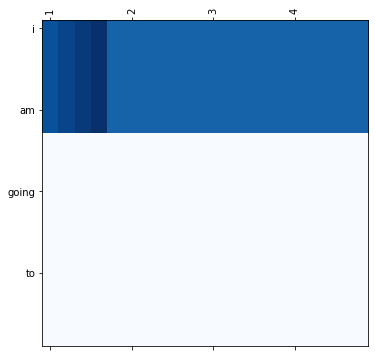

In [ ]:
pred,attention=predict('1 2 3 4','dot')
plot_attention(attention,'1 2 3 4',pred)

<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
# #Create an object of your custom model.
# #Compile and train your model on dot scoring function.
# # Visualize few sentences randomly in Test data
# # Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# # https://www.nltk.org/_modules/nltk/translate/bleu_score.html

# #Sample example
# import nltk.translate.bleu_score as bleu
# reference = ['i am groot'.split(),] # the original
# translation = 'it is ship'.split() # trasilated using model
# print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))

In [ ]:
ita=validation['italian'].values[:1000]
eng=validation['english_out'].values[:1000]
blue=[]
for i in range(1000):
  pred_bl,att_bl=predict(ita[i],'dot')
  blue.append(bleu_score.sentence_bleu(eng[i],pred_bl))
print(f'Bleu_score: {np.average(blue)}')

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Bleu_score: 0.8246226835237551


In [ ]:
print(f'Bleu Score: {np.average(blue)}')

Bleu Score: 0.8246226835237551


<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [ ]:
#Compile and train your model on general scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [ ]:
logdir3 = os.path.join("logs3", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback3= tf.keras.callbacks.TensorBoard(logdir1, histogram_freq=1)

In [ ]:
model3 = encoder_decoder(input_len=20,output_len=20,score_ecm='general',att_units=64,batch_size=1024)
model3.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy')
train_steps3=train.shape[0]//1024
valid_steps3=validation.shape[0]//1024

In [ ]:
model3.fit(train_load, steps_per_epoch=train_steps3, epochs=20, validation_data=train_load, validation_steps=valid_steps3,callbacks=[tensorboard_callback3])

Epoch 1/20
274/274 [==============================] - 170s 602ms/step - loss: 2.3031 - val_loss: 2.2873
Epoch 2/20
274/274 [==============================] - 161s 587ms/step - loss: 2.0556 - val_loss: 2.0834
Epoch 3/20
274/274 [==============================] - 169s 616ms/step - loss: 1.9527 - val_loss: 2.0697
Epoch 4/20
274/274 [==============================] - 161s 588ms/step - loss: 1.9027 - val_loss: 2.0626
Epoch 5/20
274/274 [==============================] - 169s 618ms/step - loss: 1.8735 - val_loss: 2.0988
Epoch 6/20
274/274 [==============================] - 163s 593ms/step - loss: 1.9859 - val_loss: 2.0837
Epoch 7/20
274/274 [==============================] - 161s 588ms/step - loss: 2.0781 - val_loss: 2.1448
Epoch 8/20
274/274 [==============================] - 169s 616ms/step - loss: 1.9704 - val_loss: 2.0715
Epoch 9/20
274/274 [==============================] - 169s 618ms/step - loss: 1.8394 - val_loss: 2.0547
Epoch 10/20
274/274 [==============================] - 172s 627m

In [ ]:
model3.summary()

Model: "encoder_decoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_4 (Encoder)          multiple                  1643268   
_________________________________________________________________
decoder_6 (Decoder)          multiple                  5296558   
Total params: 6,939,826
Trainable params: 6,939,826
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%tensorboard --logdir logs3

In [ ]:
import matplotlib.ticker as ticker
def plot_attention(attention,act,pred):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate

  pred,_=predict(act,plot_t2='general')
  plot_att=attention[:len(pred.split(' ')),len(act.split(' '))]
  fig,ax = plt.subplots(figsize=(8,6))
  ax.matshow(attention,cmap='Blues')
  ax.set_xticklabels([''] + act.split(' '), rotation=90)
  ax.set_yticklabels([''] + pred.split(' '))
  plt.show() 
  

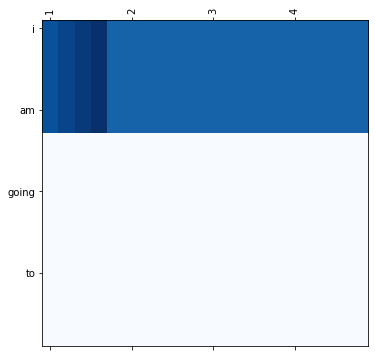

In [ ]:
pred,attention=predict('1 2 3 4','general')
plot_attention(attention,'1 2 3 4',pred)

In [ ]:
def predict(input_sentence,plot_t2):

  sentences=[]
  in_enc_ita=tknizer_ita.texts_to_sequences([input_sentence])
  in_pad_seq_ita=pad_sequences(in_enc_ita,maxlen=20,padding='post',truncating='post',dtype='int32')
  state_enc1=model3.layers[0].initialize_states(in_pad_seq_ita.shape[0])
  enc_ouput1,enc_state_h1,enc_state_c1=model3.layers[0](in_pad_seq_ita,state_enc1)
  in_indexs=tknizer_eng.word_index['<start>']
  in_indexs=tf.expand_dims([in_indexs],0)
  att=np.zeros((20,20))
  input_list=[]
  for j in range(in_pad_seq_ita.shape[1]):
    out_pred,dec_state_h1,dec_state_c1,w,cv=model3.layers[1].onestep_decoder(in_indexs,enc_ouput1,enc_state_h1,enc_state_c1)
    dense_out1=model3.layers[1](in_indexs,enc_ouput1,enc_state_h1,enc_state_c1)
    out_index=np.argmax(dense_out1)
    wt=tf.reshape(w,(-1, ))
    att[j]=wt.numpy()
    in_indexs=np.reshape(out_index,(1,1))
    input_list.append(tknizer_eng.index_word[out_index])
    if tknizer_eng.index_word[out_index]=='<end>':
      break
  return ' '.join(input_list),att


In [ ]:
ita=validation['italian'].values[:1000]
eng=validation['english_out'].values[:1000]
blue=[]
for i in range(1000):
  pred_bl,att_bl=predict(ita[i],'general')
  blue.append(bleu_score.sentence_bleu(eng[i],pred_bl))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print(f'Bleu_score: {np.average(blue)}')

Bleu_score: 0.8705149732218294


<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [ ]:
#Compile and train your model on concat scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [ ]:
logdir4 = os.path.join("logs4", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback4= tf.keras.callbacks.TensorBoard(logdir1, histogram_freq=1)

In [ ]:
model4 = encoder_decoder(input_len=20,output_len=20,score_ecm='concat',att_units=64,batch_size=1024)
model4.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy')
train_steps3=train.shape[0]//1024
valid_steps3=validation.shape[0]//1024

In [ ]:
model4.fit(train_load, steps_per_epoch=train_steps3, epochs=20, validation_data=train_load, validation_steps=valid_steps3,callbacks=[tensorboard_callback4])

Epoch 1/20
274/274 [==============================] - 187s 659ms/step - loss: 2.3358 - val_loss: 2.2126
Epoch 2/20
274/274 [==============================] - 184s 671ms/step - loss: 1.9897 - val_loss: 2.1768
Epoch 3/20
274/274 [==============================] - 183s 669ms/step - loss: 1.9982 - val_loss: 2.0986
Epoch 4/20
274/274 [==============================] - 183s 669ms/step - loss: 1.9786 - val_loss: 2.1295
Epoch 5/20
274/274 [==============================] - 184s 672ms/step - loss: 1.8858 - val_loss: 2.1411
Epoch 6/20
274/274 [==============================] - 177s 647ms/step - loss: 1.8964 - val_loss: 2.1293
Epoch 7/20
274/274 [==============================] - 176s 644ms/step - loss: 1.9157 - val_loss: 2.0868
Epoch 8/20
274/274 [==============================] - 176s 644ms/step - loss: 1.9690 - val_loss: 2.0937
Epoch 9/20
274/274 [==============================] - 182s 664ms/step - loss: 1.8564 - val_loss: 2.0578
Epoch 10/20
274/274 [==============================] - 184s 672m

In [ ]:
model4.summary()

Model: "encoder_decoder_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_5 (Encoder)          multiple                  1643268   
_________________________________________________________________
decoder_7 (Decoder)          multiple                  5329519   
Total params: 6,972,787
Trainable params: 6,972,787
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model4.save_weights('concat_model4.h5')

In [ ]:
!kill 1690

In [ ]:
def predict(input_sentence,plot_t2):

  sentences=[]
  in_enc_ita=tknizer_ita.texts_to_sequences([input_sentence])
  in_pad_seq_ita=pad_sequences(in_enc_ita,maxlen=20,padding='post',truncating='post',dtype='int32')
  state_enc1=model4.layers[0].initialize_states(in_pad_seq_ita.shape[0])
  enc_ouput1,enc_state_h1,enc_state_c1=model4.layers[0](in_pad_seq_ita,state_enc1)
  in_indexs=tknizer_eng.word_index['<start>']
  in_indexs=tf.expand_dims([in_indexs],0)
  att=np.zeros((20,20))
  input_list=[]
  for j in range(in_pad_seq_ita.shape[1]):
    out_pred,dec_state_h1,dec_state_c1,w,cv=model4.layers[1].onestep_decoder(in_indexs,enc_ouput1,enc_state_h1,enc_state_c1)
    dense_out1=model4.layers[1](in_indexs,enc_ouput1,enc_state_h1,enc_state_c1)
    out_index=np.argmax(dense_out1)
    wt=tf.reshape(w,(-1, ))
    att[j]=wt.numpy()
    in_indexs=np.reshape(out_index,(1,1))
    input_list.append(tknizer_eng.index_word[out_index])
    if tknizer_eng.index_word[out_index]=='<end>':
      break
  return ' '.join(input_list),att


In [ ]:
import matplotlib.ticker as ticker
def plot_attention(attention,act,pred):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate

  pred,_=predict(act,plot_t2='concat')
  plot_att=attention[:len(pred.split(' ')),len(act.split(' '))]
  fig,ax = plt.subplots(figsize=(8,6))
  ax.matshow(attention,cmap='Blues')
  ax.set_xticklabels([''] + act.split(' '), rotation=90)
  ax.set_yticklabels([''] + pred.split(' '))
  plt.show() 
  

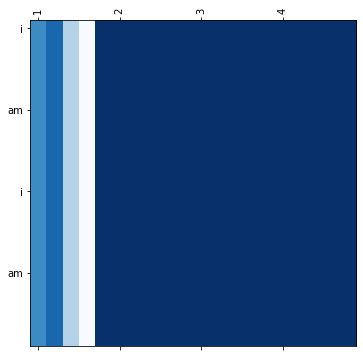

In [ ]:
pred,attention=predict('1 2 3 4','concat')
plot_attention(attention,'1 2 3 4',pred)

In [ ]:
ita=validation['italian'].values[:1000]
eng=validation['english_out'].values[:1000]
blue=[]
for i in range(1000):
  pred_bl,att_bl=predict(ita[i],'concat')
  blue.append(bleu_score.sentence_bleu(eng[i],pred_bl))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print(f'Bleu_score: {np.average(blue)}')

Bleu_score: 0.5097968335141377


In [ ]:
# Write your observations on each of the scoring function

**OBSERVATIONS OF ATTENTION MECHANISM**

In [34]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["No","Scoring Function", "Bleu Score"]

x.add_row(["1","Dot",0.8325 ])
x.add_row(["2","General", 0.8614])
x.add_row(["3","Concat ", 0.510])
print(x)

+----+------------------+------------+
| No | Scoring Function | Bleu Score |
+----+------------------+------------+
| 1  |       Dot        |   0.8325   |
| 2  |     General      |   0.8614   |
| 3  |     Concat       |    0.51    |
+----+------------------+------------+
